In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.io
import cmocean 
import sys
sys.path.insert(1, '/Users/emmagurcan/Documents/France/ENS/M1/stageM1/analysis')
from functions_MSM74 import *
import fonctions as f
import matplotlib.ticker as ticker
import netCDF4 as nc
import cartopy.crs as ccrs
import gsw
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import griddata
from matplotlib.colors import Normalize
from geopy.distance import geodesic

In [2]:
woa_temp = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/2015-2022_mean/summer/woa_temp.nc"
woa_sal = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/2015-2022_mean/summer/woa_sal.nc"

raw_ctd = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/raw_ctd.nc"
ds_clean = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_ctd.nc"
clean_lonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_lonlatev.nc"
nclonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_lonlat.nc"
readcp = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74-VMADCP_allfiles/msm_074_1_vmadcp_75khz_01.nc"
rep = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_CTD.tab"
lon_lat_event = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/lon_lat_event.nc"
rep = '/Users/emmagurcan/Documents/France/ENS/M1/stageM1'
uCTD = scipy.io.loadmat(rep+'/Data/Data_MSM40/UCTD_dataproc.mat')
adcp = scipy.io.loadmat(rep +'/Data/Data_MSM40/adcp_150kHz/TL_GEOMAR_150_STJOHNS_BREST_000_000000_6_hc.mat')
bathymetry = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/bathymetry/etopo2.nc"

In [3]:
ds = nc.Dataset(woa_temp)
dss = nc.Dataset(woa_sal)
# ds14 = nc.Dataset(woa_path14)
ds_adcp = nc.Dataset(readcp)
ds_ctd = nc.Dataset(ds_clean)
lonlatev = nc.Dataset(clean_lonlat)

In [4]:
rep = '/Users/emmagurcan/Documents/France/ENS/M1/stageM1'
uCTD = scipy.io.loadmat(rep+'/Data/Data_MSM40/UCTD_dataproc.mat')
adcp = scipy.io.loadmat(rep +'/Data/Data_MSM40/adcp_150kHz/TL_GEOMAR_150_STJOHNS_BREST_000_000000_6_hc.mat')

In [5]:
# Define the section (section 2 can't be plotted => no uCTD measures)
section_num = 5
sub_section = 1
start_index, end_index, len_section, start_index_adcp, end_index_adcp = f.section(section_num)
name = f'section_{section_num}'
# inv_x = 0
if section_num == 4:
    inv_x = 1
cruise = "MSM40"
set_maxdepth(cruise)
extent=[-70, -25, 50, 70]
if sub_section < 3:
    extent=[-70, -15, 50, 70]
if section_num == 1:
    extent=[-70, -25, 40, 70]

In [6]:
# Define depth limit for uCTD
depth_max=300

# Define depth limit for ADCP
depth_max_adcp=300

# Create depth array
depth = np.arange(0, 1001)

In [9]:
start_index, end_index, len_section, start_index_adcp, end_index_adcp = f.section(section_num)
name = f'section_{section_num}'
inv_x = 0

# Define depth limit for uCTD
depth_max=300

# Define depth limit for ADCP
depth_max_adcp=300

# Create depth array
depth = np.arange(0, 1001)

# CTD data
lon = np.squeeze(uCTD['uctdlon'])[start_index:end_index+1]
lat = np.squeeze(uCTD['uctdlat'])[start_index:end_index+1]
T = np.squeeze(uCTD['Tgrid'])[:,start_index:end_index+1]
PD = np.squeeze(uCTD['PDgrid'])[:,start_index:end_index+1]
S = np.squeeze(uCTD['Sgrid'])[:,start_index:end_index+1]
press = uCTD['pressure']


# Select adcp data
b = adcp['b']
bb = b[0,0]
ref = bb[0][0,0][0]
nav = bb[2][0,0][0]
vel = bb[1]
u = vel[:,0,:] + ref[0,:] # vitesse zonale, positive vers l'est
v = vel[:,1,:] + ref[1,:] # vitesse méridionale, positive vers le nord
depth_adcp = bb[3][0]
LON_adcp = nav[1,:]
LAT_adcp = nav[2,:]
LAT = LAT_adcp[start_index_adcp:end_index_adcp+1]
LON = LON_adcp[start_index_adcp:end_index_adcp+1]
u_section = u[:,start_index_adcp:end_index_adcp+1]
v_section = v[:,start_index_adcp:end_index_adcp+1]

if section_num == 5:
    splits = [-45.168683, -53.5, -60.0843339]
    start = splits[sub_section - 1]
    stop = splits[sub_section]
    valid_ctd = np.where(np.logical_and(lon < start, lon > stop))
    lon = lon[valid_ctd]
    lat = lat[valid_ctd]
    T = T[:, valid_ctd].squeeze()
    PD = PD[:, valid_ctd].squeeze()
    S = S[:, valid_ctd].squeeze()
    valid_adcp = np.where(np.logical_and(LON < start, LON > stop))
    LAT = LAT[valid_adcp]
    LON = LON[valid_adcp]
    u_section = u_section[:, valid_adcp].squeeze()
    v_section = v_section[:, valid_adcp].squeeze() 

if section_num == 7:
    splits = np.linspace(np.max(lon), np.min(lon), 4)
    start = splits[sub_section - 1]
    stop = splits[sub_section]
    valid_ctd = np.where(np.logical_and(lon < start, lon > stop))
    lon = lon[valid_ctd]
    lat = lat[valid_ctd]
    T = T[:, valid_ctd].squeeze()
    PD = PD[:, valid_ctd].squeeze()
    S = S[:, valid_ctd].squeeze()
    valid_adcp = np.where(np.logical_and(LON < start, LON > stop))
    LAT = LAT[valid_adcp]
    LON = LON[valid_adcp]
    u_section = u_section[:, valid_adcp].squeeze()
    v_section = v_section[:, valid_adcp].squeeze()

u_adcp = u_section
v_adcp = v_section
d1 = np.sin(lat*(math.pi/180))*np.sin(lat[0]*(math.pi/180))
d2 = np.cos(lat*(math.pi/180))*np.cos(lat[0]*(math.pi/180)) * \
    np.cos(abs(lon[0]-lon)*(math.pi/180))
distance = 6371*np.arccos(d1+d2)


d1_adcp = np.sin(LAT*(math.pi/180))*np.sin(LAT[0]*(math.pi/180))
d2_adcp = np.cos(LAT*(math.pi/180))*np.cos(LAT[0]*(math.pi/180)) * \
    np.cos(abs(LON[0]-LON)*(math.pi/180))
distance_adcp = 6371*np.arccos(d1_adcp+d2_adcp)


v_ortho = calc_ortho_vel(section_num, cruise, LON, LAT, u_section, v_section)
mdepth = get_maxdepth()
ndepth = get_numdepth()

sigma_grid = PD
s_grid = S
t_grid = T

SA = gsw.SA_from_SP(S, press, lon, lat)  # Longitude and Latitude needed
CT = gsw.CT_from_t(SA, T, press)

# N2 analysis
N2, p_mid = gsw.Nsquared(SA, CT, press, lat=lat)
idx_max = np.nanargmax(N2, axis=0)
depth_max_N2 = depth[idx_max] 

xs = distance
zs = depth
yl = 300
lons_unique = unique_preserve_order(lon)
lats_unique = unique_preserve_order(lat)

offset = geodesic((lat[0], lon[0]), (LAT[0], LON[0])).kilometers



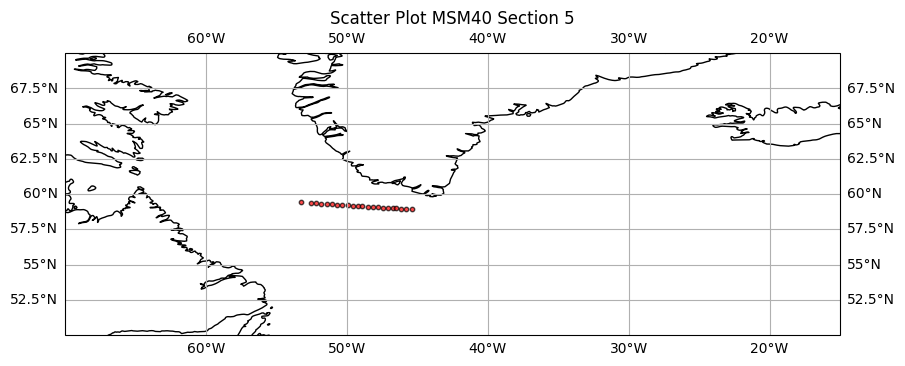

In [10]:
plot_coords(lon, lat, title=f"Scatter Plot MSM40 Section {section_num}", extent=extent)

In [11]:
tref, sref, lon_sel, lat_sel, depth_ref = get_reference_profile(cruise, section_num, ds, dss, lon, lat, CT, SA, distance, depth, sub_section=sub_section)

    
anomalyt, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "temperature")
anomalys, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "salinity")
anomalyp, ind_X, ind_Z = anom(tref, sref, lon_sel, lat_sel, depth_ref, CT, SA, sigma_grid, distance, "density")


300.0
0.0


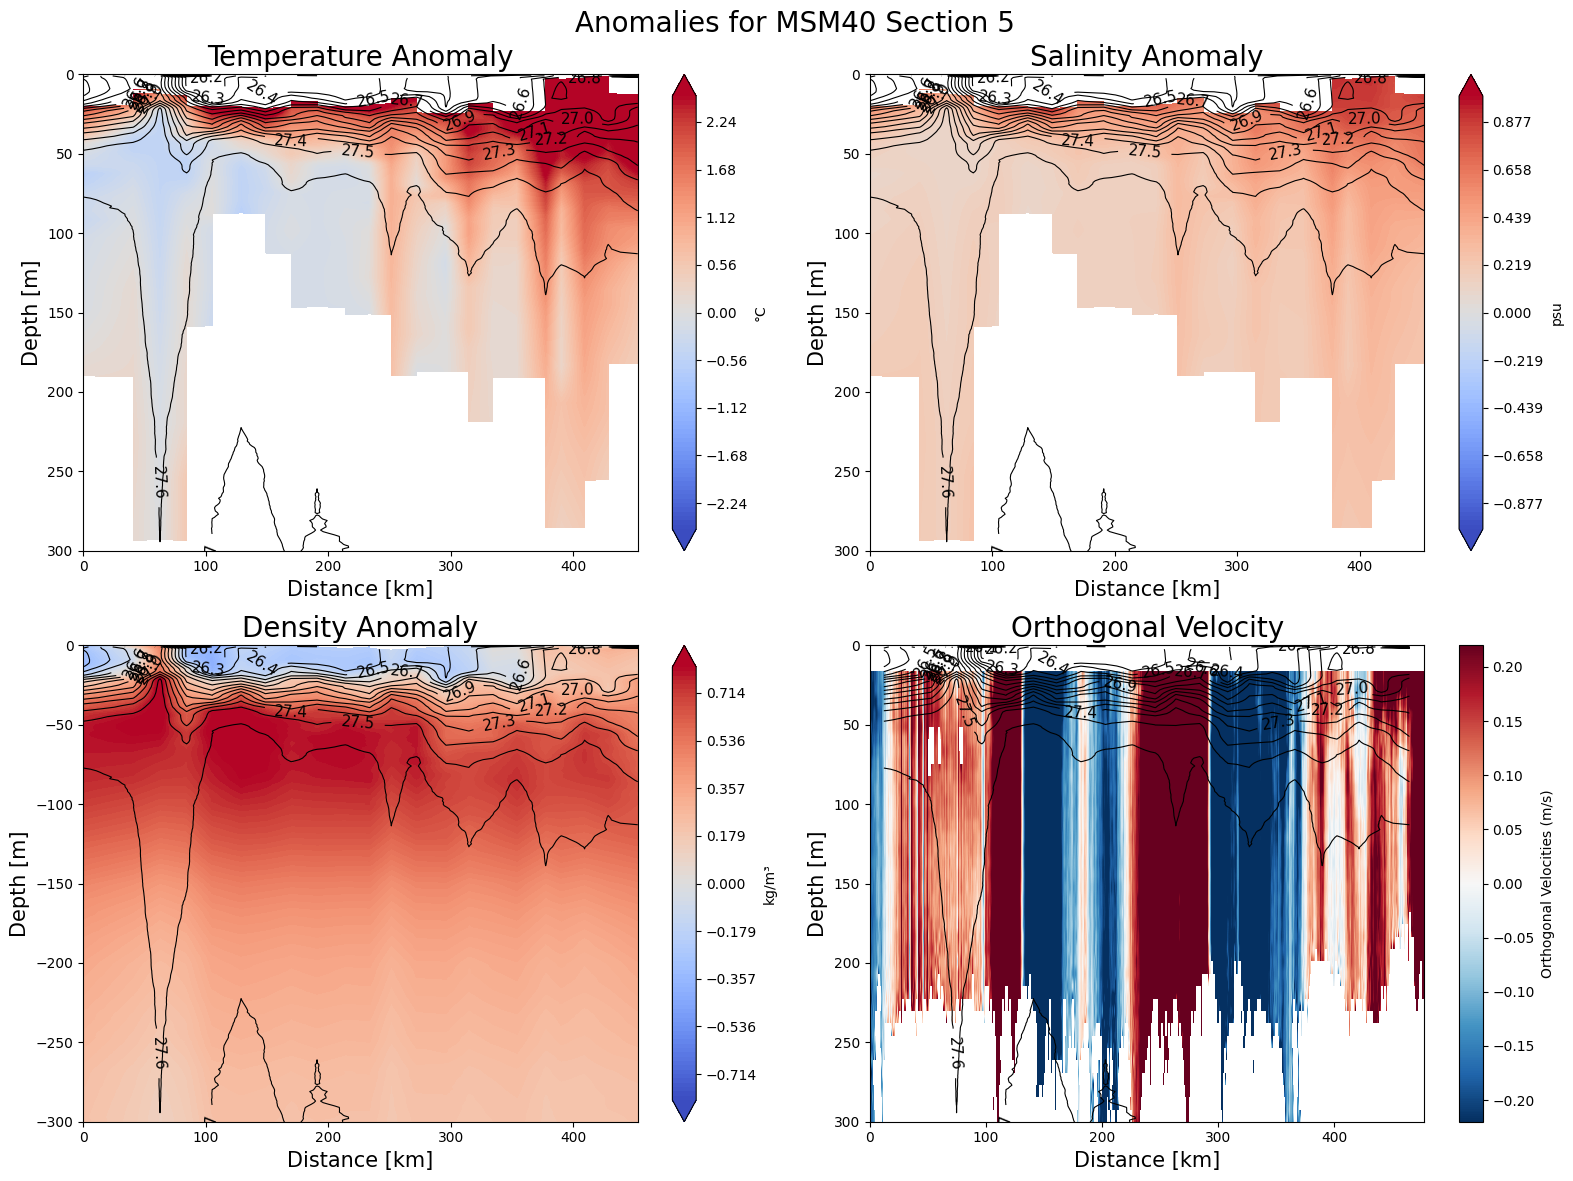

In [14]:
plot_anomalies(distance, ind_Z, anomalyt, anomalys, anomalyp, depth, sigma_grid, v_ortho, depth_adcp, distance_adcp, section_num, saturation=0.75, saturationd = 0.3, inv_x=0, cruise="MSM40", offset=offset)